## Generate Docstring for Python Functions (2 Epochs)

Dataset Source: https://huggingface.co/datasets/calum/the-stack-smol-python-docstrings

#### Install Necessary Libraries

In [1]:
%pip install rouge_score tensorboard

You should consider upgrading via the '/Users/briandunn/Documents/deep_learning/dl/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [2]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import set_seed, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

import torch
from torch.utils.data import DataLoader

import datasets
from datasets import load_dataset, DatasetDict, Dataset
import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [3]:
n = 18

print("Library/Language:".rjust(n), "Version")
print("Python:".rjust(n), sys.version[0:6])
print("NumPy:".rjust(n), np.__version__)
print("Pandas:".rjust(n), pd.__version__)
print("Torch:".rjust(n), torch.__version__)
print("Datasets:".rjust(n), datasets.__version__)
print("Transformers:".rjust(n), transformers.__version__)
print("Evaluate:".rjust(n), evaluate.__version__)

 Library/Language: Version
           Python: 3.9.12
            NumPy: 1.24.2
           Pandas: 2.0.0
            Torch: 2.0.0
         Datasets: 2.11.0
     Transformers: 4.27.4
         Evaluate: 0.4.0


#### Ingest Dataset

In [4]:
dataset = load_dataset("calum/the-stack-smol-python-docstrings")

dataset

Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/calum___parquet/calum--the-stack-smol-python-docstrings-21ab0798f01e04a9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['body', 'body_hash', 'docstring', 'path', 'name', 'repository_name', 'lang', 'body_without_docstring'],
        num_rows: 24616
    })
})

#### Convert to Pandas DataFrame

In [5]:
dataset.set_format("pandas")
df = dataset['train'][:]

df

,body,body_hash,docstring,path,name,repository_name,lang,body_without_docstring
0,def _canonicalize_experiment(exp):\n 'Sorts...,-8215901732217586742,Sorts the repeated fields of an Experiment mes...,tensorboard/plugins/hparams/backend_context_te...,_canonicalize_experiment,aryaman4/tensorboard,python,def _canonicalize_experiment(exp):\n \n ...
1,"def __init__(self, request_id=None, return_cod...",2894216753114153542,ResumeProcessesResponse - a model defined in S...,lib/services/vautoscaling/ncloud_vautoscaling/...,__init__,NaverCloudPlatform/ncloud-sdk-python,python,"def __init__(self, request_id=None, return_cod..."
2,@property\ndef request_id(self):\n 'Gets th...,-1183890875359341296,Gets the request_id of this ResumeProcessesRes...,lib/services/vautoscaling/ncloud_vautoscaling/...,request_id,NaverCloudPlatform/ncloud-sdk-python,python,@property\ndef request_id(self):\n 'Gets th...
3,"@request_id.setter\ndef request_id(self, reque...",-8333445982014422093,Sets the request_id of this ResumeProcessesRes...,lib/services/vautoscaling/ncloud_vautoscaling/...,request_id,NaverCloudPlatform/ncloud-sdk-python,python,"@request_id.setter\ndef request_id(self, reque..."
4,@property\ndef return_code(self):\n 'Gets t...,5002841652600357537,Gets the return_code of this ResumeProcessesRe...,lib/services/vautoscaling/ncloud_vautoscaling/...,return_code,NaverCloudPlatform/ncloud-sdk-python,python,@property\ndef return_code(self):\n 'Gets t...
...,...,...,...,...,...,...,...,...
24611,@read_session\ndef list_identities(session=Non...,-8399802736883936158,Returns a list of all identities.\n\n:param se...,lib/rucio/core/identity.py,list_identities,Pranay144/rucio,python,@read_session\ndef list_identities(session=Non...
24612,@read_session\ndef list_accounts_for_identity(...,7104951005997468497,Returns a list of all accounts for an identity...,lib/rucio/core/identity.py,list_accounts_for_identity,Pranay144/rucio,python,@read_session\ndef list_accounts_for_identity(...
24613,def test_plain_ansi(self):\n '\n Tes...,2886767279122754110,Test that printable characters do not get mang...,evennia/server/portal/tests.py,test_plain_ansi,Antrare/evennia,python,def test_plain_ansi(self):\n '\n \n ...
24614,def test_identity(self):\n '\n Test ...,-7974552474826718259,Test that the composition of the function and\...,evennia/server/portal/tests.py,test_identity,Antrare/evennia,python,def test_identity(self):\n '\n Test ...


#### Drop unnecessary features & Other Text Cleaning

In [6]:
df = df.drop(columns=["repository_name", "path", "body_hash", "body", "lang", "name"])

df = df.rename(columns={"body_without_docstring": "text"})
df['text'] = df['text'].apply(lambda x: x.strip())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24616 entries, 0 to 24615
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   docstring  24616 non-null  object
 1   text       24616 non-null  object
dtypes: object(2)
memory usage: 384.8+ KB


#### Visualize: Word Length of Code (Input)

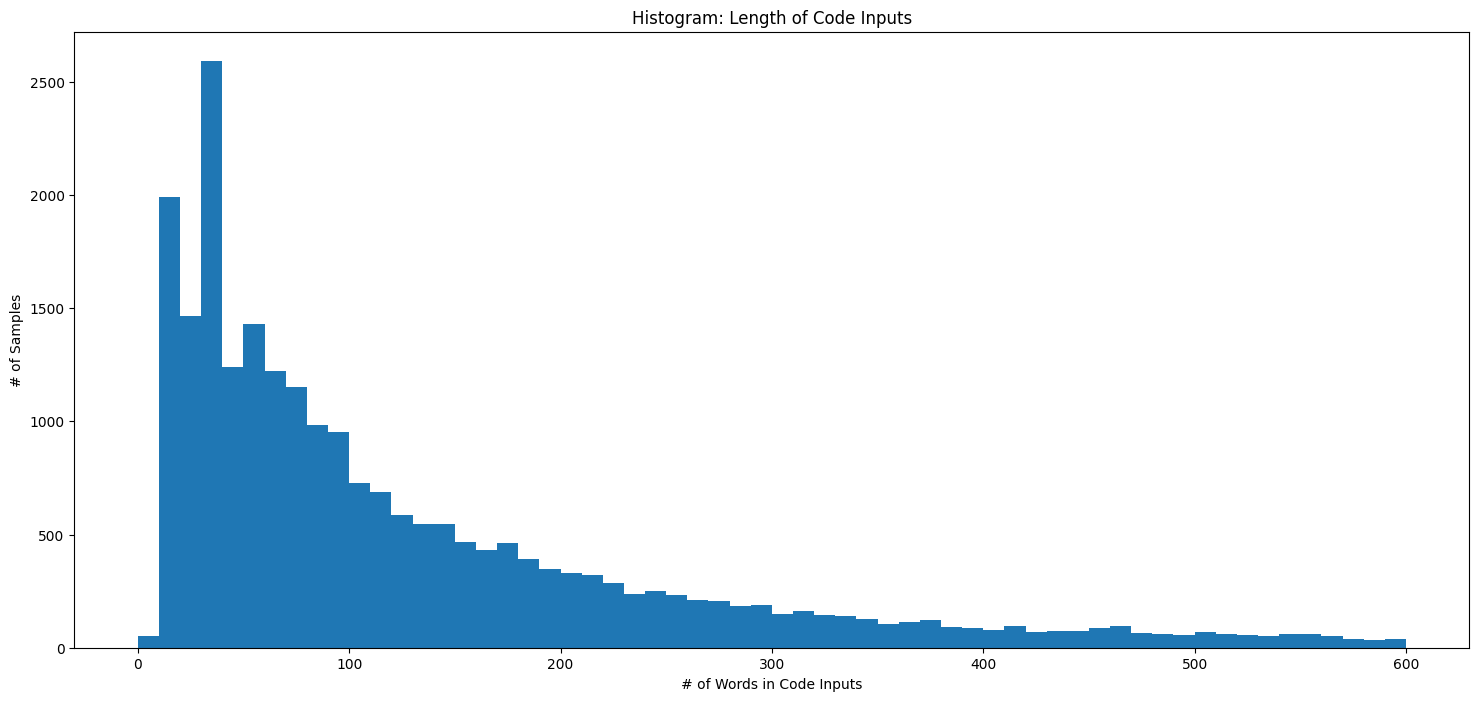

The maximum length of Code Inputs (in words) is 11431 words.


In [7]:
df['code_length'] = df['text'].str.split(" ").str.len()

n_bin=600
df.hist('code_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=int(n_bin/10))
plt.title('Histogram: Length of Code Inputs')
plt.xlabel('# of Words in Code Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Code Inputs (in words) is {max(df['code_length'])} words.")

#### Visualize: Word Length of Docstrings (Output)

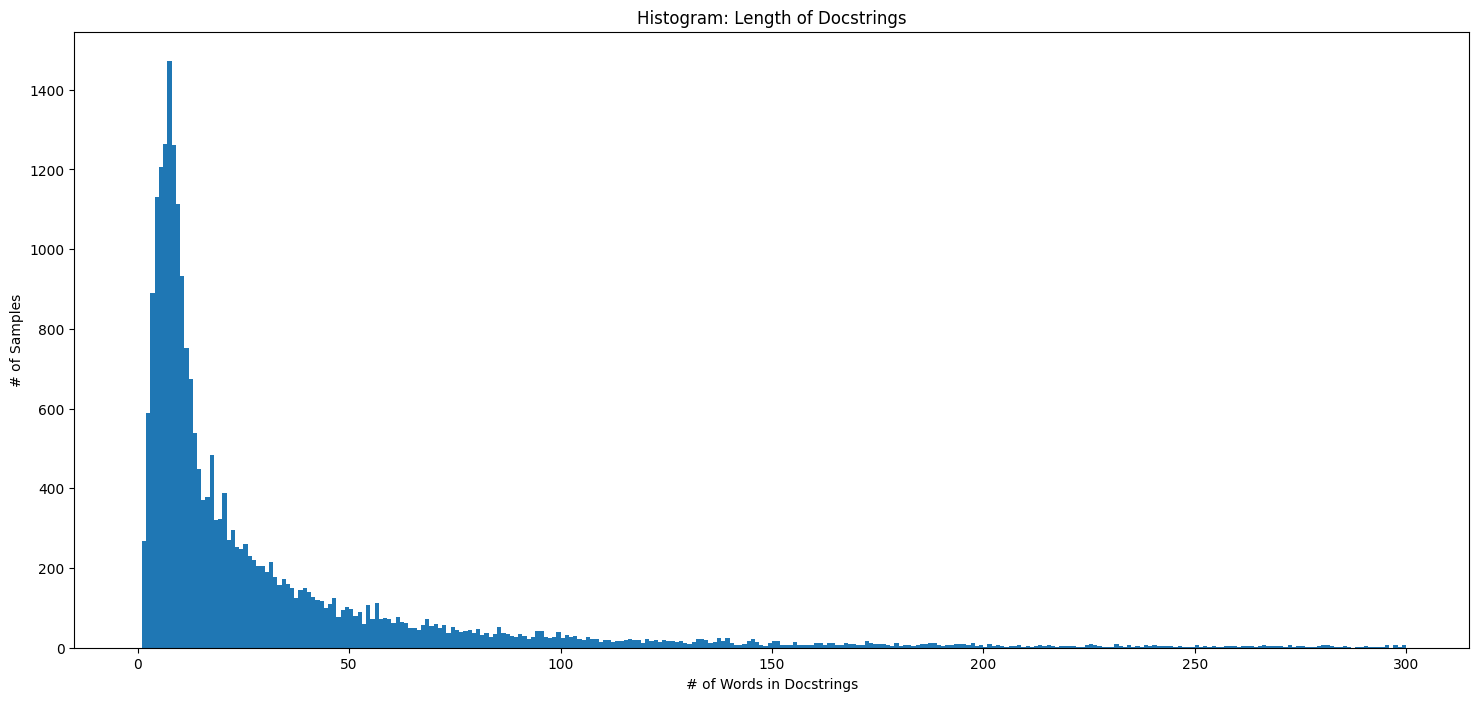

The maximum length of Docstrings (in words) is 3954 words.


In [8]:
df['docstring_length'] = df['docstring'].str.split(" ").str.len()

n_bin=300
df.hist('docstring_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Docstrings')
plt.xlabel('# of Words in Docstrings')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Docstrings (in words) is {max(df['docstring_length'])} words.")

#### Trim Overly Lengthy Code Samples & Docstrings as Well as Remove Unnecessary Features

In [9]:
df = df[df['code_length'] < 250]
df = df[df['docstring_length'] < 125]

df = df.drop(columns=['code_length', 'docstring_length'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19644 entries, 0 to 24615
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   docstring  19644 non-null  object
 1   text       19644 non-null  object
dtypes: object(2)
memory usage: 460.4+ KB


#### Convert DataFrame Back to Dataset

In [10]:
dataset = Dataset.from_pandas(df)

#### Split Code into Training/Testing/Evaluation Datasets

In [11]:
train_valid = dataset.train_test_split(train_size=0.75)

ds = DatasetDict({
    'train': train_valid['train'], 
    'eval': train_valid['test']})

print('Training data shape:', ds['train'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (14733, 3)
Validation data shape: (4911, 3)


#### Print an Example

In [12]:
example = ds['train'][5]

print("Code:")
print(example["text"])
print("\nDocstring:")
print(example["docstring"])

Code:
def fit_predict(self, X, delayed=True):
    '\n        Compute cluster centers and predict cluster index for each sample.\n\n        Parameters\n        ----------\n        X : Dask cuDF DataFrame or CuPy backed Dask Array\n            Data to predict\n\n        Returns\n        -------\n        result: Dask cuDF DataFrame or CuPy backed Dask Array\n            Distributed object containing predictions\n\n        '
    return self.fit(X).predict(X, delayed=delayed)

Docstring:
Compute cluster centers and predict cluster index for each sample.

Parameters
----------
X : Dask cuDF DataFrame or CuPy backed Dask Array
    Data to predict

Returns
-------
result: Dask cuDF DataFrame or CuPy backed Dask Array
    Distributed object containing predictions


#### Basic Values/Constants

In [13]:
MODEL_CKPT = "Salesforce/codet5-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Generate_Docstrings_for_Python-Condensed"

T5_PREFIX = "Summarize python: "
NUM_OF_EPOCHS = 2

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

DEVICE = torch.device("cpu")
set_seed = 42

LR = 2e-5
BATCH_SIZE = 16

#### Instantiate Tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

#### Define Function for Preprocessing Dataset

In [15]:
def preprocess_samples(samples):
    codes = samples['text']
    docstrings = samples['docstring']
    
    inputs = [T5_PREFIX + code for code in codes]
    model_inputs = tokenizer(inputs,
                             padding="max_length", 
                             truncation=True)
    
    labels = tokenizer(docstrings,
                       padding="max_length", 
                       truncation=True
                       ).input_ids
    
    labels_with_ignore_index = []
    for label_ex in labels:
        label_ex = [label if label != 0 else -100 for label in label_ex]
        labels_with_ignore_index.append(label_ex)
    
    model_inputs["labels"] = labels_with_ignore_index
    
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [16]:
encoded_ds = ds.map(preprocess_samples, 
                         batched=True)

Map:   0%|          | 0/14733 [00:00<?, ? examples/s]

Map:   0%|          | 0/4911 [00:00<?, ? examples/s]

#### Check That Preprocessing Worked as Expected

In [17]:
encoded_ds

DatasetDict({
    train: Dataset({
        features: ['docstring', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14733
    })
    eval: Dataset({
        features: ['docstring', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4911
    })
})

#### Define Data Collator

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_CKPT)

#### Define Function to Compute Metrics

In [19]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(preds):
    predictions, labels = preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

#### Define Model

In [20]:
model = (AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)).to(DEVICE)

#### Define TrainingArguments

In [24]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME,
                         num_train_epochs=NUM_OF_EPOCHS,
                         report_to=REPORTS_TO,
                         learning_rate=LR,
                         logging_strategy=STRATEGY,
                         log_level="error",
                         evaluation_strategy=STRATEGY,
                         per_device_train_batch_size=BATCH_SIZE,
                         per_device_eval_batch_size=BATCH_SIZE,
                         save_strategy=STRATEGY,
                         predict_with_generate=True,
                         logging_first_step=True,
                         hub_private_repo=True,
                         push_to_hub=True
                         )

#### Define Trainer

In [25]:
trainer = Seq2SeqTrainer(model=model,
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds['train'],
                  eval_dataset=encoded_ds['eval'])

/Users/briandunn/Desktop/Code Commenting/codet5-base-Generate_Docstrings_for_Python-Condensed is already a clone of https://huggingface.co/DunnBC22/codet5-base-Generate_Docstrings_for_Python-Condensed. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train Model

In [26]:
training_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1842 [00:00<?, ?it/s]

{'loss': 8.3414, 'learning_rate': 1.998914223669924e-05, 'epoch': 0.0}
{'loss': 0.8261, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_loss': 0.6434808373451233, 'eval_rouge1': 0.4947, 'eval_rouge2': 0.3661, 'eval_rougeL': 0.4794, 'eval_rougeLsum': 0.4791, 'eval_gen_len': 13.7526, 'eval_runtime': 13492.27, 'eval_samples_per_second': 0.364, 'eval_steps_per_second': 0.023, 'epoch': 1.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.6234, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_loss': 0.6199244260787964, 'eval_rouge1': 0.5017, 'eval_rouge2': 0.374, 'eval_rougeL': 0.4866, 'eval_rougeLsum': 0.4864, 'eval_gen_len': 13.8909, 'eval_runtime': 14513.404, 'eval_samples_per_second': 0.338, 'eval_steps_per_second': 0.021, 'epoch': 2.0}
{'train_runtime': 246509.2727, 'train_samples_per_second': 0.12, 'train_steps_per_second': 0.007, 'train_loss': 0.7288453773100912, 'epoch': 2.0}


#### Evaluate Model

In [27]:
score = trainer.evaluate()
print(score)

  0%|          | 0/307 [00:00<?, ?it/s]

{'eval_loss': 0.6199244260787964, 'eval_rouge1': 0.5017, 'eval_rouge2': 0.374, 'eval_rougeL': 0.4866, 'eval_rougeLsum': 0.4864, 'eval_gen_len': 13.8909, 'eval_runtime': 14141.2926, 'eval_samples_per_second': 0.347, 'eval_steps_per_second': 0.022, 'epoch': 2.0}


#### Push Model to Hub (My Profile!!!)

In [28]:
trainer.push_to_hub()

Upload file runs/Apr14_19-18-57_Brians-Mac-mini.local/events.out.tfevents.1681517941.Brians-Mac-mini.local.868…

Upload file runs/Apr14_19-18-57_Brians-Mac-mini.local/events.out.tfevents.1681778592.Brians-Mac-mini.local.868…

To https://huggingface.co/DunnBC22/codet5-base-Generate_Docstrings_for_Python-Condensed
   f62f8b9..caa0312  main -> main

   f62f8b9..caa0312  main -> main

To https://huggingface.co/DunnBC22/codet5-base-Generate_Docstrings_for_Python-Condensed
   caa0312..657b9da  main -> main

   caa0312..657b9da  main -> main



'https://huggingface.co/DunnBC22/codet5-base-Generate_Docstrings_for_Python-Condensed/commit/caa031296aadcde6225c2b27a933f44aded08dde'

### Notes & Other Takeaways From This Project
****
- I made three modifications from the initial CodeT5 project. They are: 
    - Use the codet5-base checkpoint instead of the codet5-small checkpoint.
    - Instead of manually removing comments from the function body, I used the column with the comments already removed from the functions.
    - I am running this project for two epochs instead of 4 epochs.

****

### Citations

- Model Checkpoint
    > @misc{wang2021codet5, title={CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation}, author={Yue Wang and Weishi Wang and Shafiq Joty and Steven C. H. Hoi}, year={2021}, eprint={2109.00859}, archivePrefix={arXiv}, primaryClass={cs.CL}
}

- Metric (Rouge)
    > @inproceedings{lin-2004-rouge,
    title = "{ROUGE}: A Package for Automatic Evaluation of Summaries",
    author = "Lin, Chin-Yew",
    booktitle = "Text Summarization Branches Out",
    month = jul,
    year = "2004",
    address = "Barcelona, Spain",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/W04-1013",
    pages = "74--81",
}